<a href="https://colab.research.google.com/github/priyamankar14/Traffic-detection-system-/blob/main/Final_Traffic_Detection_(MRSAC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install required libraries
!pip install ultralytics opencv-python matplotlib deap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.4 MB/s eta 0:00:00


In [2]:
# Step 2: Import libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np
from deap import base, creator, tools, algorithms
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Step 3: Upload 4 traffic images
print("Upload exactly 4 images (each showing a traffic signal):")
uploaded = files.upload()
image_paths = list(uploaded.keys())[:4]
if len(image_paths) != 4:
    raise ValueError("Please upload exactly 4 images.")


Upload exactly 4 images (each showing a traffic signal):


Saving S5.jpg to S5.jpg
Saving S4.jpg to S4.jpg
Saving Signal1.jpg to Signal1.jpg
Saving S2.jpg to S2.jpg


In [4]:
 # Step 4: Load a more accurate YOLOv8 model (Open Images V7)
model = YOLO("yolov8s-oiv7.pt")  # pretrained on OpenImagesV7

# Define class IDs
vehicle_class_ids = [90, 73, 558, 342, 550]  # Car, Bus, Truck, Motorcycle, Train
ambulance_class_id = 6
van_class_id = 564  # fuzzy logic previously used

vehicle_counts = []
ambulance_present = []
images = []


100%|██████████| 21.9M/21.9M [00:01<00:00, 16.5MB/s]


In [5]:
# Step 5: Detection
for img_path in image_paths:
    print(f"\nAnalyzing Image: {img_path}")
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(img_rgb, imgsz=640)
    res = results[0]
    boxes = res.boxes

    xyxy = boxes.xyxy.cpu().numpy()
    confs = boxes.conf.cpu().numpy()
    cls_ids = boxes.cls.cpu().numpy().astype(int)

    vehicle_count = 0
    ambulance_flag = False

    for (x1, y1, x2, y2), conf, cls in zip(xyxy, confs, cls_ids):
        label = model.names[cls].lower()
        print(f"  Detected: {label} (ID {cls}) with confidence {conf:.2f}")

        if conf < 0.2:
            continue  # Slightly lowered threshold to catch motorcycles

        is_ambulance = (
            cls == ambulance_class_id or
            'ambulance' in label or
            (cls == van_class_id and conf > 0.7)
        )

        if is_ambulance:
            ambulance_flag = True
            vehicle_count += 1  # Count ambulance as a vehicle
            cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
            cv2.putText(img_rgb, "AMBULANCE",
                        (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        elif cls in vehicle_class_ids:
            vehicle_count += 1
            cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(img_rgb, label.capitalize(), (int(x1), int(y1) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    vehicle_counts.append(vehicle_count)
    ambulance_present.append(ambulance_flag)

    # Annotate vehicle count
    cv2.putText(img_rgb, f"Vehicles: {vehicle_count}",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                (255, 0, 0) if ambulance_flag else (255, 255, 0), 2)

    images.append(img_rgb)




Analyzing Image: S5.jpg

0: 640x640 2 Cars, 1 Van, 858.4ms
Speed: 18.2ms preprocess, 858.4ms inference, 37.8ms postprocess per image at shape (1, 3, 640, 640)
  Detected: van (ID 564) with confidence 0.72
  Detected: car (ID 90) with confidence 0.59
  Detected: car (ID 90) with confidence 0.31

Analyzing Image: S4.jpg

0: 640x480 23 Cars, 3 Taxis, 1 Wheel, 533.4ms
Speed: 4.4ms preprocess, 533.4ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 480)
  Detected: car (ID 90) with confidence 0.76
  Detected: car (ID 90) with confidence 0.71
  Detected: car (ID 90) with confidence 0.70
  Detected: car (ID 90) with confidence 0.69
  Detected: car (ID 90) with confidence 0.67
  Detected: car (ID 90) with confidence 0.63
  Detected: car (ID 90) with confidence 0.61
  Detected: car (ID 90) with confidence 0.60
  Detected: car (ID 90) with confidence 0.59
  Detected: car (ID 90) with confidence 0.55
  Detected: car (ID 90) with confidence 0.54
  Detected: car (ID 90) with confidence

In [6]:
# Step 6: Genetic Algorithm setup
CYCLE_TIME, MIN_GREEN, MAX_GREEN, N_SIGNALS = 120, 10, 60, 4

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate(ind):
    total = sum(ind)
    if total == 0:
        return -float('inf'),
    norm = [t * CYCLE_TIME / total for t in ind]
    if any(t < MIN_GREEN or t > MAX_GREEN for t in norm):
        return -float('inf'),
    total_vehicles = sum(vehicle_counts)
    if total_vehicles == 0:
        return -float('inf'),
    ideal = [v / total_vehicles for v in vehicle_counts]
    actual = [t / CYCLE_TIME for t in norm]
    dev = sum((i - a) ** 2 for i, a in zip(ideal, actual))
    return -dev,

def init_individual():
    vals = [random.uniform(MIN_GREEN, MAX_GREEN) for _ in range(N_SIGNALS)]
    total = sum(vals)
    return creator.Individual([v * CYCLE_TIME / total for v in vals])

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=50)
for _ in range(100):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.3)
    fits = list(map(toolbox.evaluate, offspring))
    for ind, fit in zip(offspring, fits):
        ind.fitness.values = fit
    pop = toolbox.select(offspring, k=len(pop))

best = tools.selBest(pop, k=1)[0]
green_times = [round(t * CYCLE_TIME / sum(best), 1) for t in best]



In [7]:
# Step 7: Prioritize ambulance signals
for i in range(N_SIGNALS):
    if ambulance_present[i]:
        green_times[i] = MAX_GREEN

# Normalize if total time exceeds cycle
total_time = sum(green_times)
if total_time > CYCLE_TIME:
    extra = total_time - CYCLE_TIME
    other_idxs = [i for i in range(N_SIGNALS) if not ambulance_present[i]]
    total_other = sum(green_times[i] for i in other_idxs)
    for i in other_idxs:
        green_times[i] -= extra * (green_times[i] / total_other)



/tmp/ipython-input-8-2883623756.py:11: UserWarning: Glyph 128657 (\N{AMBULANCE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128657 (\N{AMBULANCE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


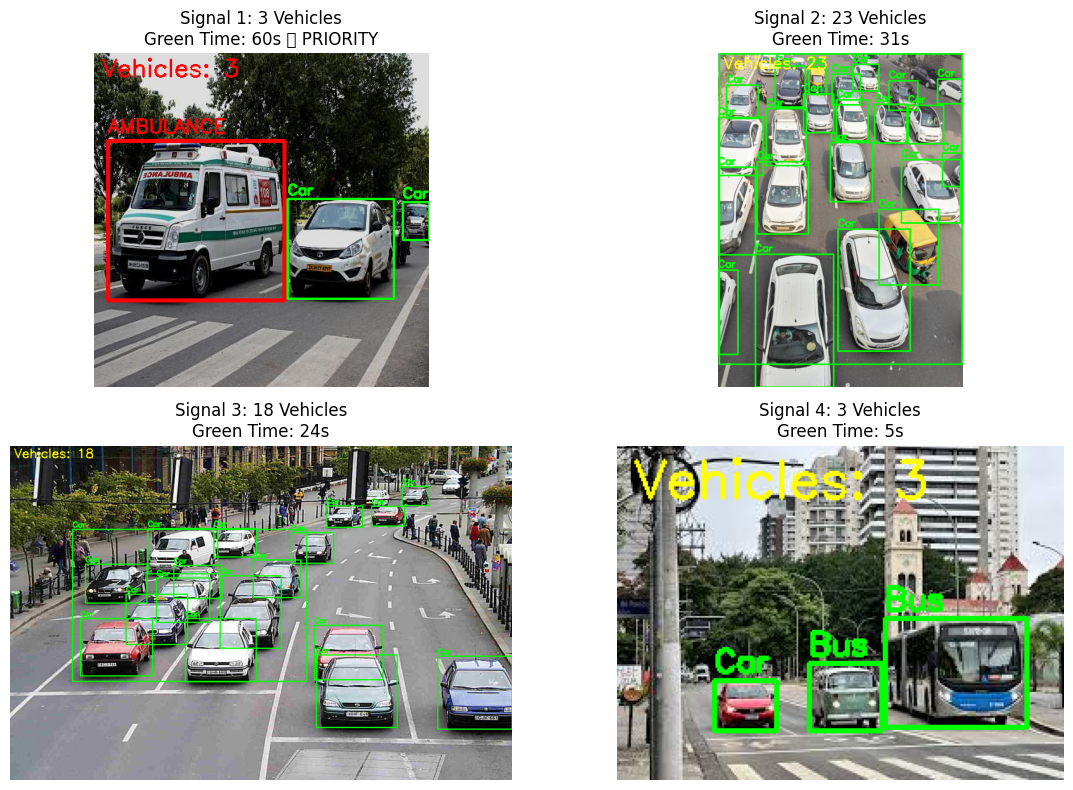

In [8]:
# Step 8: Show annotated images
plt.figure(figsize=(12, 8))
for i, (img, vc, gt, amb) in enumerate(zip(images, vehicle_counts, green_times, ambulance_present)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')
    title = f"Signal {i+1}: {vc} Vehicles\nGreen Time: {round(gt)}s"
    if amb:
        title += " 🚑 PRIORITY"
    plt.title(title)
plt.tight_layout()
plt.show()


In [9]:
# Step 9: Print results
print("\nVehicle Counts and Green Times (w/ Ambulance Priority):")
for i in range(4):
    priority = " 🚑" if ambulance_present[i] else ""
    print(f"Signal {i+1}: {vehicle_counts[i]} vehicles → Green Time: {round(green_times[i])}s{priority}")




Vehicle Counts and Green Times (w/ Ambulance Priority):
Signal 1: 3 vehicles → Green Time: 60s 🚑
Signal 2: 23 vehicles → Green Time: 31s
Signal 3: 18 vehicles → Green Time: 24s
Signal 4: 3 vehicles → Green Time: 5s


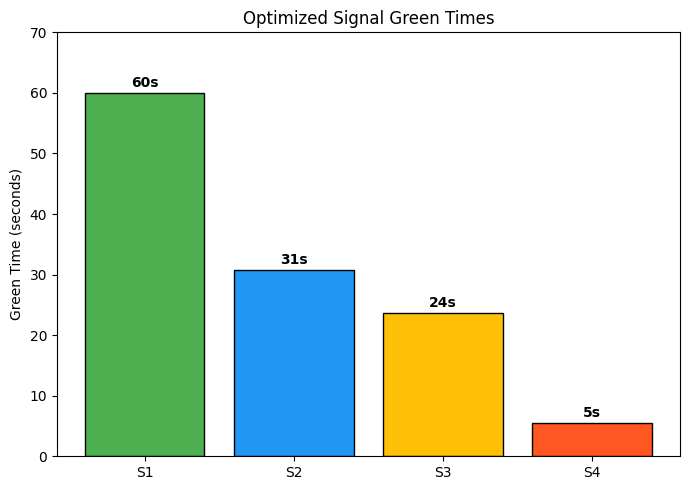

In [10]:
# Step 10: Bar chart of green times
plt.figure(figsize=(7, 5))
labels = [f"S{i+1}" for i in range(4)]
colors = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722']
plt.bar(labels, green_times, color=colors, edgecolor='black')
plt.ylabel("Green Time (seconds)")
plt.title("Optimized Signal Green Times")
for i, v in enumerate(green_times):
    plt.text(i, v + 1, f"{round(v)}s", ha='center', fontweight='bold')
plt.ylim(0, MAX_GREEN + 10)
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Install required libraries
!pip install ultralytics opencv-python matplotlib deap pytesseract --quiet
!apt-get install -y tesseract-ocr  # Required for pytesseract

# Step 2: Import libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np
import pytesseract

# Step 3: Upload 4 images
print("Upload exactly 4 images (each showing a traffic signal):")
uploaded = files.upload()
image_paths = list(uploaded.keys())[:4]
if len(image_paths) != 4:
    raise ValueError("Please upload exactly 4 images.")

# Step 4: Load YOLOv8x model
model = YOLO("yolov8x.pt")

# COCO class IDs for vehicles
vehicle_class_ids = [2, 3, 5, 7]  # Car, Motorcycle, Bus, Truck

vehicle_counts = []
ambulance_present = []
images = []

# Step 5: Detection
for img_path in image_paths:
    print(f"\nAnalyzing Image: {img_path}")
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not load image {img_path}")
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(img_rgb, imgsz=1280, conf=0.1)  # Higher resolution, lower conf for sensitivity
    res = results[0]
    boxes = res.boxes

    xyxy = boxes.xyxy.cpu().numpy()
    confs = boxes.conf.cpu().numpy()
    cls_ids = boxes.cls.cpu().numpy().astype(int)

    vehicle_count = 0
    ambulance_flag = False

    for (x1, y1, x2, y2), conf, cls in zip(xyxy, confs, cls_ids):
        label = model.names[cls].lower()
        print(f"  Detected: {label} (ID {cls}) with confidence {conf:.2f}")

        # Skip low-confidence detections for non-vehicles
        if conf < 0.2 and cls not in vehicle_class_ids:
            continue
        if "motorcycle" in label and conf < 0.15:
            continue

        # Ambulance detection logic
        is_ambulance = False
        if cls in [2, 7]:  # Check for Car or Truck, as ambulances are often classified as these
            # Crop ROI for OCR
            roi = img[int(y1):int(y2), int(x1):int(x2)]
            if roi.size == 0:
                continue
            # Perform OCR to detect "AMBULANCE" text
            ocr_text = pytesseract.image_to_string(roi, config='--psm 6').lower()
            if "ambulance" in ocr_text or (cls == 7 and conf > 0.7):  # Truck with high confidence as fallback
                is_ambulance = True

        if is_ambulance:
            ambulance_flag = True
            vehicle_count += 1
            cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
            cv2.putText(img_rgb, "AMBULANCE",
                        (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        elif cls in vehicle_class_ids:
            vehicle_count += 1
            cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Fixed syntax
            cv2.putText(img_rgb, label.capitalize(), (int(x1), int(y1) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    vehicle_counts.append(vehicle_count)
    ambulance_present.append(ambulance_flag)

    # Annotate vehicle count
    cv2.putText(img_rgb, f"Vehicles: {vehicle_count}",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                (255, 0, 0) if ambulance_flag else (255, 255, 0), 2)

    images.append(img_rgb)

# Step 6: Display results
print("\nAmbulance Detection Results:")
for i in range(len(image_paths)):
    priority = " 🚑" if ambulance_present[i] else ""
    print(f"Signal {i+1}: {vehicle_counts[i]} vehicles, Ambulance Detected: {ambulance_present[i]}{priority}")

# Step 7: Show annotated images
plt.figure(figsize=(12, 8))
for i, (img, vc, amb) in enumerate(zip(images, vehicle_counts, ambulance_present)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')
    title = f"Signal {i+1}: {vc} Vehicles"
    if amb:
        title += " 🚑 AMBULANCE"
    plt.title(title)
plt.tight_layout()
plt.show()